# PyVWF: Running multiple scenarios and plotting

This notebook exists for research purposes to easily run and compare all the various variations of this model:
- How spatial (no. of clusters) and temporal (from yearly to monthly) 

This code can take a long time to run as training needs to occur dependent on number of clusters.

In [1]:
import vwf.VWF_Model as model

In [2]:
# time_res_list = ['yearly', 'season', 'bimonth', 'month']
time_res_list = ['yearly', 'season', 'bimonth', 'month']

# cluster_list = [1,10,100,500,750,1000,2000,3000,3700]
# cluster_list = [1,10,100,500,1000]
cluster_list = [1,10,100,1000]
# cluster_list = [500,2000,4000]
country = "DK"
year_test = 2020 # year you wish to receive a time series for

# cluster_list = [1,10,100,250,500,600]
# country = "DE"
# year_test = 2019 # year you wish to receive a time series for

In [3]:
vwf_model = model.VWF(country)
vwf_model.prep()

In [4]:
vwf_model.train(cluster_list, time_res_list)

Total observed turbines/farms before conditions:  5623
Number of valid observed turbines/farms:  3707
Training for  1  clusters with time resolution:  yearly  is taking place.
Training completed and saved. Elapsed time: 28.31 seconds
 
Training for  1  clusters with time resolution:  season  is taking place.
Training completed and saved. Elapsed time: 15.68 seconds
 
Training for  1  clusters with time resolution:  bimonth  is taking place.
Training completed and saved. Elapsed time: 14.65 seconds
 
Training for  1  clusters with time resolution:  month  is taking place.
Training completed and saved. Elapsed time: 21.93 seconds
 
Training for  10  clusters with time resolution:  yearly  is taking place.
Training completed and saved. Elapsed time: 17.55 seconds
 
Training for  10  clusters with time resolution:  season  is taking place.
Training completed and saved. Elapsed time: 32.09 seconds
 
Training for  10  clusters with time resolution:  bimonth  is taking place.
Training complet

In [5]:
vwf_model.test(year_test,cluster_list,time_res_list)

Total observed turbines/farms before conditions:  5623
Number of valid observed turbines/farms:  5348
Test for  1  clusters with time resolution:  yearly  is taking place.
Results completed and saved. Elapsed time: 3.00 seconds
 
Test for  1  clusters with time resolution:  season  is taking place.
Results completed and saved. Elapsed time: 3.01 seconds
 
Test for  1  clusters with time resolution:  bimonth  is taking place.
Results completed and saved. Elapsed time: 3.00 seconds
 
Test for  1  clusters with time resolution:  month  is taking place.
Results completed and saved. Elapsed time: 2.97 seconds
 
Test for  10  clusters with time resolution:  yearly  is taking place.
Results completed and saved. Elapsed time: 3.02 seconds
 
Test for  10  clusters with time resolution:  season  is taking place.
Results completed and saved. Elapsed time: 3.06 seconds
 
Test for  10  clusters with time resolution:  bimonth  is taking place.
Results completed and saved. Elapsed time: 2.99 seconds


In [6]:
# # running for merra

# vwf_model = model.VWF(country, year_star, year_end, year_test)
# vwf_model.test_merra(time_res)

In [7]:
# import time
# import xarray as xr
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from vwf.extras import calc_metrics_era5
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib

bg_colour = '#f0f0f0'
custom_params = {'xtick.bottom': True, 'axes.edgecolor': 'black', 'axes.spines.right': False, 'axes.spines.top': False, 'axes.facecolor': bg_colour}
sns.set_theme(style='darkgrid', rc=custom_params)

In [8]:
clus_metrics, month_metrics  = calc_metrics_era5(year_test, country, cluster_list, time_res_list) 

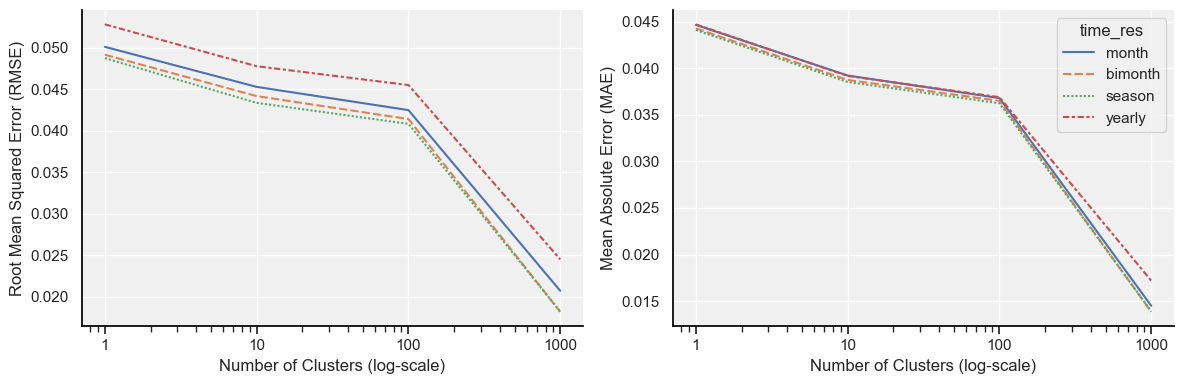

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.lineplot(
    x='num_clu',
    y='RMSE',
    hue ="time_res",
    style="time_res",
    hue_order = ['month', 'bimonth', 'season', 'yearly'],
    style_order= ['month', 'bimonth', 'season', 'yearly'],
    data = clus_metrics[(clus_metrics['time_res'] != 'uncorrected')],
    ax = axes[0],
    legend = False
)
axes[0].set_xscale('log')
axes[0].set_ylabel('Root Mean Squared Error (RMSE)')
axes[0].set_xlabel('Number of Clusters (log-scale)')
axes[0].set_xticks([1, 10, 100,1000])
axes[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

sns.lineplot(
    x='num_clu',
    y='MAE',
    hue ="time_res",
    style= "time_res",
    hue_order = ['month', 'bimonth', 'season', 'yearly'],
    style_order= ['month', 'bimonth', 'season', 'yearly'],
    data = clus_metrics[(clus_metrics['time_res'] != 'uncorrected')],
    ax = axes[1],
    legend = True
)

axes[1].set_xscale('log')
axes[1].set_ylabel('Mean Absolute Error (MAE)')
axes[1].set_xlabel('Number of Clusters (log-scale)')
axes[1].set_xticks([1, 10, 100,1000])
axes[1].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

# fixing the legend labels and sharing it over whole plot.
# axes[1].get_legend().remove()
# handles, labels = plt.gca().get_legend_handles_labels()
# # labels = ['Monthly', 'Bimonthly',  'Seasonal', 'Yearly'] # renaming labels
# plt.legend(handles, labels, ncol=1, loc='lower left', title='Time Resolution')
plt.savefig("data/plots/"+country+"_full_error.png", bbox_inches='tight')
plt.tight_layout()